In [1]:
from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt
import numpy as np
import regions
from astropy.io import fits
from astropy import wcs
from spectral_cube import SpectralCube
from spectral_cube import Projection
import dust_emissivity
from astropy.table import Table


fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


In [2]:
ls /orange/adamginsburg/cmz/g5/G5/a/feather/spw27.SiO/

feather.last*                  g5a.TP.SiO.spw27.subim.im/
g5a.7m.SiO.spw27.gal.im/       g5a.TP.SiO.spw27.subim2.im/
g5a.7m.SiO.spw27.gal.pb.im/    g5a.feather1.SiO.spw27.im/
g5a.7m.SiO.spw27.im/           g5a.feather2.SiO.spw27.im/
g5a.7m.SiO.spw27.pb.fits*      g5a.feather2.SiO.spw27.image/
g5a.7m.SiO.spw27.pb.im/        immath.last*
g5a.7m.SiO.spw27.subim.im/     importfits.last*
g5a.7m.SiO.spw27.subim.pb.im/  imregrid.last*
g5a.TP.SiO.spw27.depb2/        imsubimage.last*
g5a.TP.SiO.spw27.im/           multi.im/
g5a.TP.SiO.spw27.regrid.im/    viewer.last*
g5a.TP.SiO.spw27.regrid2.im/


# Measurements

In [3]:
a_fixednames =['/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.12CO.spw17.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.Ha.spw19.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.CH3OH.spw21.fits',
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw23.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw25.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.SiO.spw27.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.13CO.spw29.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.C18O.spw31.fits' 
               ]

#cube_17 = SpectralCube.read(a_fixednames[0]).with_spectral_unit(u.km / u.second, velocity_convention='radio')
#cube_29 = SpectralCube.read(a_fixednames[6]).with_spectral_unit(u.km / u.second, velocity_convention='radio')
#cube_31 = SpectralCube.read(a_fixednames[7]).with_spectral_unit(u.km / u.second, velocity_convention='radio')
cube_27 = SpectralCube.read(a_fixednames[5]).with_spectral_unit(u.km / u.second, velocity_convention='radio')

In [4]:
cube_27a = cube_27.spectral_slab(55*u.km/u.second, 225*u.km/u.second)
cube_27b = cube_27.spectral_slab(-5*u.km/u.second, 55*u.km/u.second)

In [38]:
feather_file = '/orange/adamginsburg/cmz/g5/G5/a/feather/spw27.SiO/g5a.feather1.SiO.spw27.image'
cube_feather = SpectralCube.read(feather_file, format='casa_image').with_spectral_unit(u.km/u.s, velocity_convention='radio').to(u.K)

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [6]:
def noise_mask(cube, vmin, vmax, level):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def noise_mask_slab(cube, vmin, vmax, level, cut1, cut2):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.spectral_slab(cut1, cut2).max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

In [7]:
mask_27 = noise_mask(cube_27, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_27b = noise_mask_slab(cube_27, -100*u.km/u.second, -50 *u.km/u.second, 5, -5*u.km/u.second, 55*u.km/u.second)
mask_27a = noise_mask_slab(cube_27, -100*u.km/u.second, -50 *u.km/u.second, 5, 55*u.km/u.second, 225*u.km/u.second)


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out

INFO: Auto-setting vmin to -3.036e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.014e+00 [aplpy.core]
INFO: Auto-setting vmin to -3.199e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.915e+00 [aplpy.core]


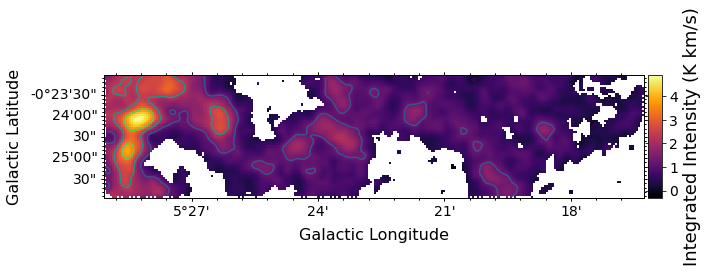

In [8]:
cube27_0 = cube_27.with_mask(mask_27).spectral_slab(-5*u.km/u.s, 225*u.km/u.s).moment0()#.with_mask(mask_17).moment0()
cube27_0.quicklook()
cube27_0.FITSFigure.show_colorscale(cmap='inferno')
cube27_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube27_0.FITSFigure.show_contour(cube27_0.hdu, returnlevels=True)
cube27_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube27_0.FITSFigure.colorbar.set_font(size=14)
cube27_0.FITSFigure.axis_labels.set_font(size=16)
cube27_0.FITSFigure.tick_labels.set_font(size=14)

In [9]:
np.nanpercentile(cube27_0, 10)

<Projection 0.42773391 K km / s>

INFO: Auto-setting vmin to -4.958e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.114e+01 [aplpy.core]
INFO: Auto-setting vmin to -5.307e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.082e+01 [aplpy.core]


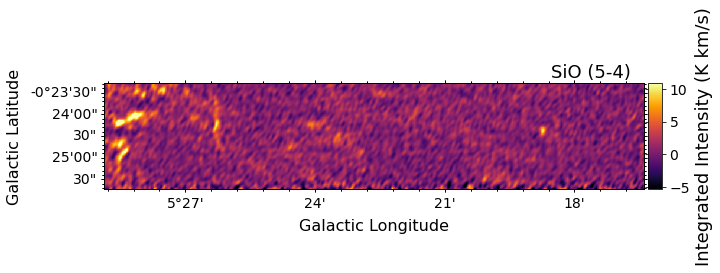

In [37]:
cubefeather_0 = cube_feather.spectral_slab(-5*u.km / u.second, 200*u.km/u.second).moment0()
cubefeather_0.quicklook()
cubefeather_0.FITSFigure.show_colorscale(cmap='inferno')
cubefeather_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
#cubefeather_0.FITSFigure.show_contour(cubefeather_0.hdu, returnlevels=True)
cubefeather_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cubefeather_0.FITSFigure.colorbar.set_font(size=14)
cubefeather_0.FITSFigure.axis_labels.set_font(size=16)
cubefeather_0.FITSFigure.tick_labels.set_font(size=14)
cubefeather_0.FITSFigure.add_label(0.9, 1.1, "SiO (5-4)", relative=True, size=18)
#cubefeather_0.FITSFigure.add_scalebar(ang, color='white', size=18)
#cubefeather_0.FITSFigure.scalebar.set_label(m)
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-lowvelo.reg')
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-highvelo.reg')
#cube17_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_17-new.pdf')

INFO: Auto-setting vmin to -4.260e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.744e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.842e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.722e+00 [aplpy.core]


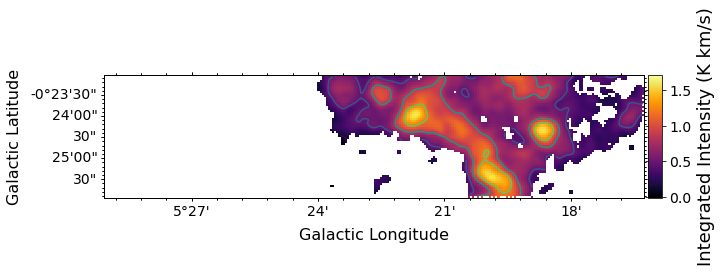

In [10]:
cube27b_0 = cube_27b.with_mask(mask_27b).moment0()#.with_mask(mask_17).moment0()
cube27b_0.quicklook()
cube27b_0.FITSFigure.show_colorscale(cmap='inferno')
cube27b_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
levs_27b = cube27b_0.FITSFigure.show_contour(cube27b_0.hdu, returnlevels=True)
cube27b_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube27b_0.FITSFigure.colorbar.set_font(size=14)
cube27b_0.FITSFigure.axis_labels.set_font(size=16)
cube27b_0.FITSFigure.tick_labels.set_font(size=14)

In [11]:
levs_27b

array([0.12302993, 0.48624932, 0.84946871, 1.2126881 , 1.57590748])

In [12]:
np.nanmax(cube27b_0)

<Projection 1.61641633 K km / s>

INFO: Auto-setting vmin to -5.353e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.391e+00 [aplpy.core]
INFO: Auto-setting vmin to -4.301e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.202e+00 [aplpy.core]


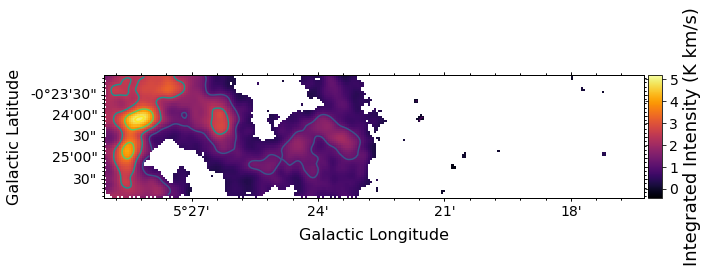

In [13]:
cube27a_0 = cube_27a.with_mask(mask_27a).moment0()#.with_mask(mask_17).moment0()
cube27a_0.quicklook()
cube27a_0.FITSFigure.show_colorscale(cmap='inferno')
cube27a_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
levs_27a = cube27a_0.FITSFigure.show_contour(cube27a_0.hdu, returnlevels=True)
cube27a_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube27a_0.FITSFigure.colorbar.set_font(size=14)
cube27a_0.FITSFigure.axis_labels.set_font(size=16)
cube27a_0.FITSFigure.tick_labels.set_font(size=14)

In [14]:
levs_27a

array([-0.04137907,  1.18151936,  2.4044178 ,  3.62731623,  4.85021467])

In [15]:
np.nanmax(cube27a_0)

<Projection 4.96137787 K km / s>

# Calculation

In [16]:
def J_nu(T, nu):
    return (const.h*nu/const.k_B)/(np.exp(const.h*nu/(const.k_B*T))-1)

INFO: Auto-setting vmin to -4.803e+11 [aplpy.core]
INFO: Auto-setting vmax to  7.862e+12 [aplpy.core]


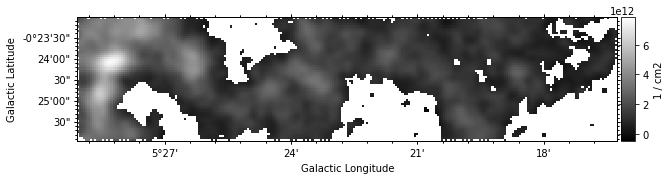

In [17]:
# SiO (5-4)
J_upper = 5
nu = cube_27.header['RESTFRQ']*u.Hz
mu = (3.098 * 10 *10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
B0 = 21711.967 * u.MHz
S = J_upper / (2*J_upper+1)
E_upper = 31.25889 * u.K
T = 60 * u.K
T_bg = 2.725 * u.K
g = 2*J_upper+1
Q_rot = (const.k_B * T) / (const.h * B0) + 1/3.


col_SiO = ((3*const.h) / (8 * np.pi**3 * S * mu**2) 
           * (Q_rot) / (g) 
           * (np.exp(E_upper / (T))) / (np.exp(const.h * nu / (const.k_B * T))-1) 
           * 1 / (J_nu(T, nu) - J_nu(T_bg, nu)) * cube27_0).to(u.cm**(-2))
col_SiO.quicklook()
col_SiO.FITSFigure.colorbar.set_axis_label_text(col_SiO.unit)

In [18]:
col_SiO.write('/orange/adamginsburg/cmz/g5/code/plots/col_SiO.fits', overwrite=True)

In [19]:
np.nanmean(col_SiO)

<Projection 1.73382126e+12 1 / cm2>

In [20]:
lte_co = 0.42
sed_fit = 0.43
x_factor = 6.52
ppmap = 0.87
col_H2 = sed_fit *10**22 * u.cm**(-2)

INFO: Auto-setting vmin to -1.080e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.733e-09 [aplpy.core]


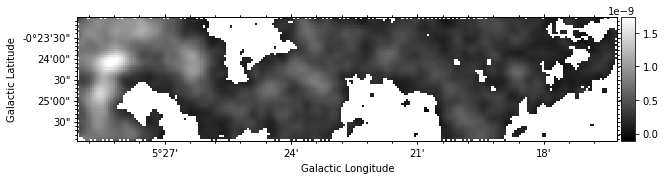

In [21]:
abundance = (col_SiO/col_H2)
abundance.quicklook()

In [22]:
np.nanmax(col_SiO)/col_H2

<Projection 1.7784691e-09>

In [23]:
np.nanmean(abundance)

<Projection 4.03214246e-10>

In [24]:
np.nanmax(abundance)

<Projection 1.7784691e-09>

In [25]:
np.nanmin(abundance)

<Projection -8.15319143e-11>

In [26]:
np.nanpercentile(abundance, 5)

<Projection 1.24552355e-10>

In [27]:
np.nanpercentile(abundance, 95)

<Projection 9.39391056e-10>

In [28]:
std_mom0 = cube_27.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(-100*u.km/u.second, -50*u.km/u.second).moment0()#.std()

INFO: Auto-setting vmin to -8.653e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.084e-01 [aplpy.core]


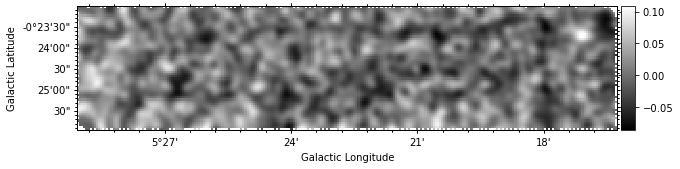

In [29]:
std_mom0.quicklook()

In [30]:
np.nanstd(std_mom0)

<Projection 0.02911643 K km / s>